# Using dask or indices for SMOC data

In this notebook we look at the effects of passing indices or chunksizes to a `FieldSet` on the execution time.
The simulation releases particles in the Southern Atlantic in the SMOC dataset on gemini. If you also run your simulation on gemini, it might be useful to evaluate which setting speeds up your runs. **Short answer: from parcels 2.2.2 the default chunksize=False is probably the quickest, and adding indices has a slight benefit.** This depends of course on the release locations and runtime of your experiment. We compare the effect of different chunksizes across different parcels versions, i.e. how useful it might be to update to master, across different runtimes, i.e. how important your choices are at different runtimes.

* [Parcels versions](#Parcels-versions)
* [Runtime](#Runtime)

In [1]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import xarray as xr
import cartopy.crs as ccrs
from os import path

This cell opens the .npy files created by the time_chunking.py simulation script.
They contain time, memory and chunking information. The parameters you can choose are the parcels versions and the runtimes for the simulations.

In [2]:
p_versions = ['2.2.0','2.2.1','2.2.2']
runtime_float = [2, 10, 30]
runtime = [timedelta(days=i) for i in runtime_float]


n_particles = np.load(f'n_particles.npy', allow_pickle=True)
chunksizes = np.load(f'chunksizes.npy', allow_pickle=True)

time = np.zeros((len(p_versions),len(runtime),len(chunksizes),len(n_particles)))
mem = np.zeros((len(p_versions),len(runtime),len(chunksizes),len(n_particles)))
chunks = np.zeros((len(p_versions),len(runtime),len(chunksizes),len(n_particles),2))

for i,v in enumerate(p_versions):
    for j, rt in enumerate(runtime):
        time[i,j] = np.load(f'execute_time_v{v}_{rt.days}d.npy', allow_pickle=True)
        mem[i,j] = np.load(f'execute_mem_v{v}_{rt.days}d.npy', allow_pickle=True)
        chunks[i,j] = np.load(f'execute_chunks_v{v}_{rt.days}d.npy', allow_pickle=True)

In [3]:
### Colormap for Parcels versions
pversion_clist = ['#F3965E','#24A793','#001240']
pversion_cmap = ListedColormap(pversion_clist)

### Colormap for different runtimes
runtime_clist = ['#AA1555','#5287C6','#FFCD00']
runtime_cmap = ListedColormap(runtime_clist)

### Colormap for different numbers of particles
nparticles_clist = ['#FFCD00','#C00A35','#5B2182']
nparticles_cmap = ListedColormap(nparticles_clist)

### Colormap for different chunksizes
cs_clist = ['#FFCD00','#F3965E','#5287C6','#AA1555','#5B2182']
cs_cmap = ListedColormap(cs_clist)

Here we look at the extent of the released particles. These particles are released on a line between 10W and 10E and 30S and 35S. With this amount of runtime the particles do not really separate into different regions.

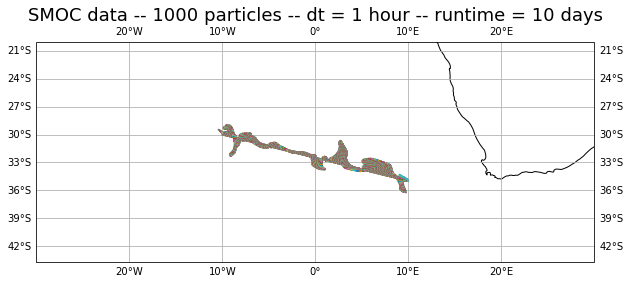

In [4]:
ds = xr.open_dataset('chunking_2.2.2_10d.nc')

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title('SMOC data -- 1000 particles -- dt = 1 hour -- runtime = 10 days', fontsize=18)
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
ax.plot(ds['lon'].T,ds['lat'].T)
ax.set_extent([-30, 30, -40, -20])
plt.show()

## Parcels versions

Most simulations with the SMOC data will run at least for about a month, if not for several years. Here we test the different chunksize arguments and look at how these effects compare across different parcels versions. In all cases, it is more time-efficient to specify which indices of your SMOC data to load than to use chunksizes. In version 2.2.0 `'auto'` is the default chunksize and the second quickest. In the latest master version this has become `'False'` because of [PR #932](https://github.com/OceanParcels/parcels/pull/932). Parcels in general has become quicker as the options `'False'` and `'indices'` in version 2.2.2 have become quicker than `'auto'` and `'indices'` in 2.2.1. **Be careful with using chunksizes as your simulation may become 100 times slower if you choose an inappropriate chunksize**.

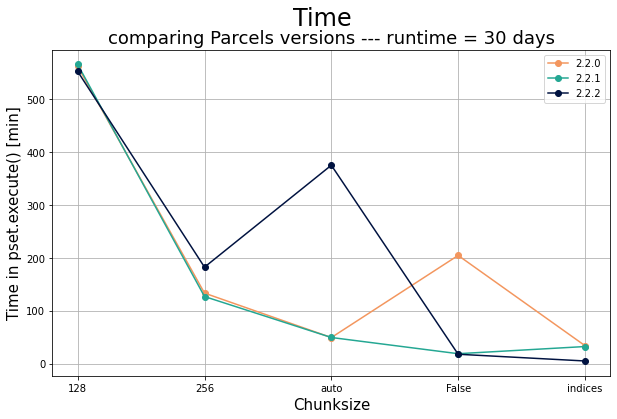

In [5]:
rt=2
fig= plt.figure(figsize = (10,6))
ax = plt.axes()

fig.suptitle('Time',fontsize=24)
ax.set_title(f'comparing Parcels versions --- runtime = {runtime[rt].days} days', fontsize=18)

for i, v in enumerate(p_versions):
    ax.plot(time[i,rt].reshape(len(chunksizes),len(n_particles))/60, marker='o',c=pversion_cmap(i), label=f'{v}')
ax.grid()

ax.set_xticks(np.arange(0,len(chunksizes)))
ax.set_xticklabels(chunksizes)
ax.set_xlabel('Chunksize', fontsize=15)
ax.set_ylabel('Time in pset.execute() [min]', fontsize= 15)
ax.legend()

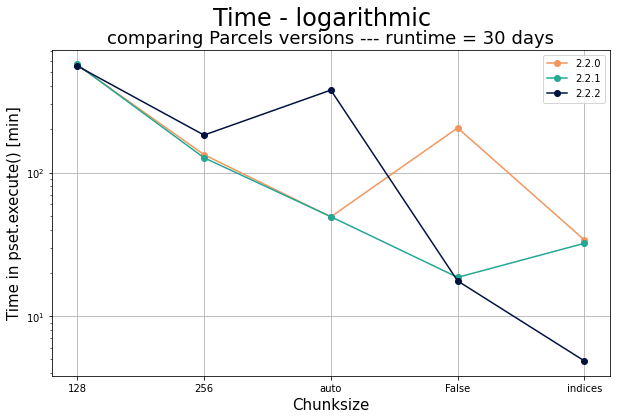

In [6]:
rt=2
fig= plt.figure(figsize = (10,6))
ax = plt.axes()

fig.suptitle('Time - logarithmic',fontsize=24)
ax.set_title(f'comparing Parcels versions --- runtime = {runtime[rt].days} days', fontsize=18)

for i, v in enumerate(p_versions):
    ax.plot(time[i,rt].reshape(len(chunksizes),len(n_particles))/60, marker='o',c=pversion_cmap(i), label=f'{v}')
ax.grid()

ax.set_xticks(np.arange(0,len(chunksizes)))
ax.set_xticklabels(chunksizes)
ax.set_xlabel('Chunksize', fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Time in pset.execute() [min]', fontsize= 15)
ax.legend()

When the fields are very large (4D, high-resolution) you may run into memory problems. Here, not specifying the chunksize has negative consequences. The False argument results in all data being loaded and is therefore not recommended if your run into memory problems. In the latest Parcels versions this effect is greatly reduced.

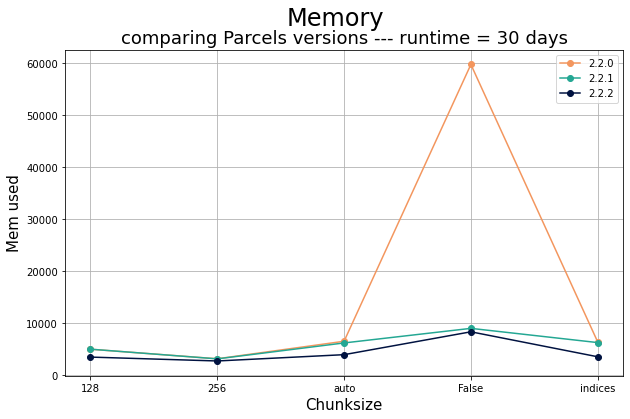

In [7]:
rt=2
fig= plt.figure(figsize = (10,6))
ax = plt.axes()

fig.suptitle('Memory',fontsize=24)
ax.set_title(f'comparing Parcels versions --- runtime = {runtime[rt].days} days', fontsize=18)

for i, v in enumerate(p_versions):
    ax.plot(mem[i,rt].reshape(len(chunksizes),len(n_particles)), marker='o',c=pversion_cmap(i), label=f'{v}')
ax.grid()

ax.set_xticks(np.arange(0,len(chunksizes)))
ax.set_xticklabels(chunksizes)
ax.set_xlabel('Chunksize', fontsize=15)
ax.set_ylabel('Mem used', fontsize= 15)
ax.legend()
plt.show()

Setting the horizontal chunksize at 128 means dask needs to load 5 chunks to find all the relevant data. It is interesting to see that a chunksize of 256 needs only one less chunk to be loaded and actually reduces both the execution time and the memory used.

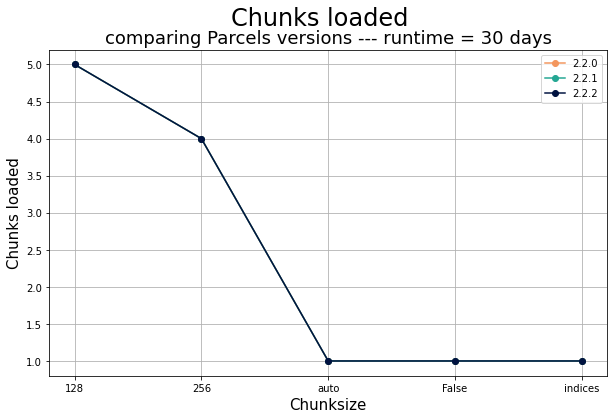

In [8]:
rt=2
fig= plt.figure(figsize = (10,6))
ax = plt.axes()

fig.suptitle('Chunks loaded',fontsize=24)
ax.set_title(f'comparing Parcels versions --- runtime = {runtime[rt].days} days', fontsize=18)

for i, v in enumerate(p_versions):
    ax.plot(chunks[i,rt,:,0,0], marker='o',c=pversion_cmap(i), label=f'{v}')
ax.grid()

ax.set_xticks(np.arange(0,len(chunksizes)))
ax.set_xticklabels(chunksizes)
ax.set_xlabel('Chunksize', fontsize=15)
ax.set_ylabel('Chunks loaded', fontsize= 15)
ax.legend()
plt.show()

The large difference in time between chunksizes of 128 and 256 is most probably caused by the total number of chunks defined by dask. With 128, dask needs to search for 5 of the 500+ chunks in which particles are present. A chunksize of 256 has significantly less chunks defined that dask has to search.

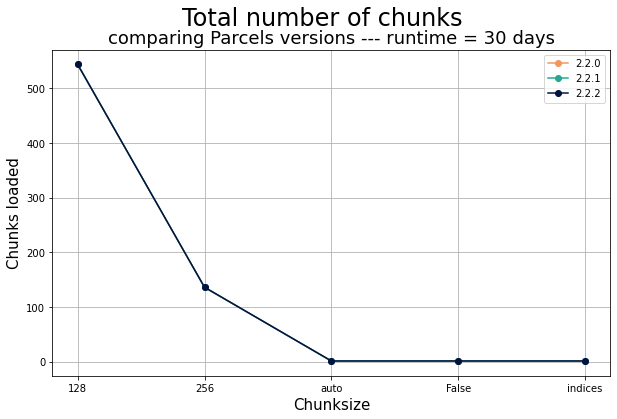

In [9]:
rt=2
fig= plt.figure(figsize = (10,6))
ax = plt.axes()

fig.suptitle('Total number of chunks',fontsize=24)
ax.set_title(f'comparing Parcels versions --- runtime = {runtime[rt].days} days', fontsize=18)

for i, v in enumerate(p_versions):
    ax.plot(chunks[i,rt,:,0,1], marker='o',c=pversion_cmap(i), label=f'{v}')
ax.grid()

ax.set_xticks(np.arange(0,len(chunksizes)))
ax.set_xticklabels(chunksizes)
ax.set_xlabel('Chunksize', fontsize=15)
ax.set_ylabel('Chunks loaded', fontsize= 15)
ax.legend()
plt.show()

## Runtime

The enormous difference in time between specifying chunksizes and using indices decreases a lot when the runtime of the simulation is shorter. That seems to indicate that the expensive part in the chunking is accessing a new chunk every timestep and the actual calculation within the chunk may be faster.

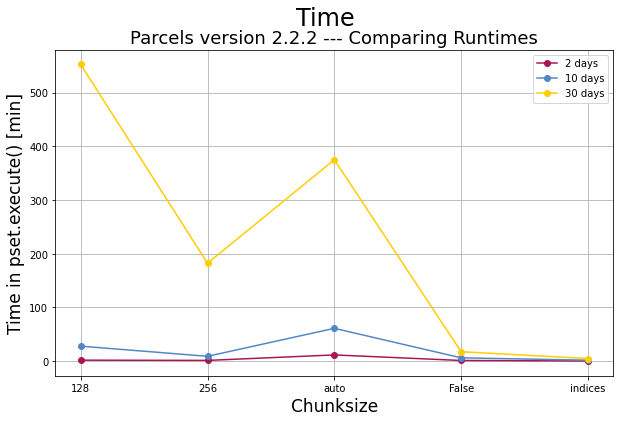

In [10]:
v=2
fig= plt.figure(figsize = (10,6))
ax = plt.axes()

fig.suptitle('Time',fontsize=24)
ax.set_title(f'Parcels version {p_versions[v]} --- Comparing Runtimes', fontsize=18)

for i, rt in enumerate(runtime):
    ax.plot(time[v,i].reshape(len(chunksizes),len(n_particles))/60, marker='o',c=runtime_cmap(i), label=f'{rt.days} days')
ax.grid()

ax.set_xticks(np.arange(0,len(chunksizes)))
ax.set_xticklabels(chunksizes)
ax.set_xlabel('Chunksize', fontsize=17)
ax.set_ylabel('Time in pset.execute() [min]', fontsize= 17)
ax.legend()

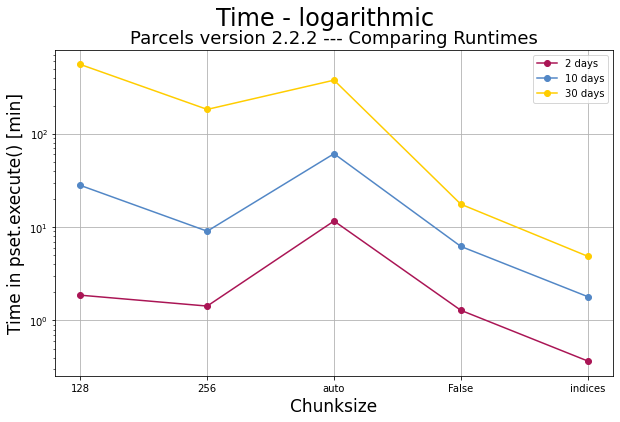

In [11]:
v=2
fig= plt.figure(figsize = (10,6))
ax = plt.axes()

fig.suptitle('Time - logarithmic',fontsize=24)
ax.set_title(f'Parcels version {p_versions[v]} --- Comparing Runtimes', fontsize=18)

for i, rt in enumerate(runtime):
    ax.plot(time[v,i].reshape(len(chunksizes),len(n_particles))/60, marker='o',c=runtime_cmap(i), label=f'{rt.days} days')
ax.grid()

ax.set_xticks(np.arange(0,len(chunksizes)))
ax.set_xticklabels(chunksizes)
ax.set_xlabel('Chunksize', fontsize=17)
ax.set_yscale('log')
ax.set_ylabel('Time in pset.execute() [min]', fontsize= 17)
ax.legend()

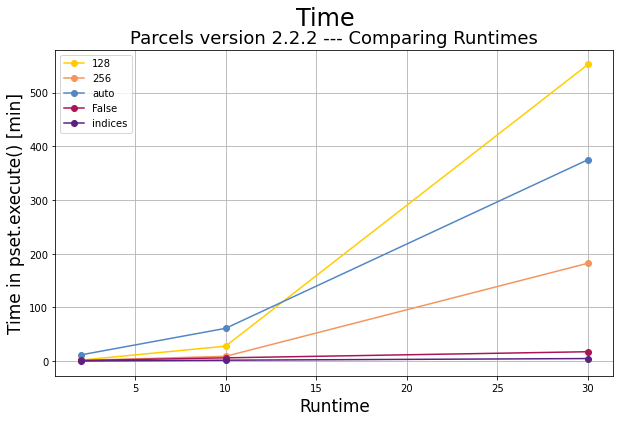

In [12]:
runtimes = np.tile(runtime_float,(len(n_particles),1)).T

v=2
fig= plt.figure(figsize = (10,6))
ax = plt.axes()

fig.suptitle('Time',fontsize=24)
ax.set_title(f'Parcels version {p_versions[v]} --- Comparing Runtimes', fontsize=18)

for i, cs in enumerate(chunksizes):
    ax.plot(runtimes,time[v,:,i].reshape(len(runtime),len(n_particles))/60, marker='o',c=cs_cmap(i), label=f'{cs}')
ax.grid()

ax.set_xlabel('Runtime', fontsize=17)
ax.set_ylabel('Time in pset.execute() [min]', fontsize= 17)
ax.legend()

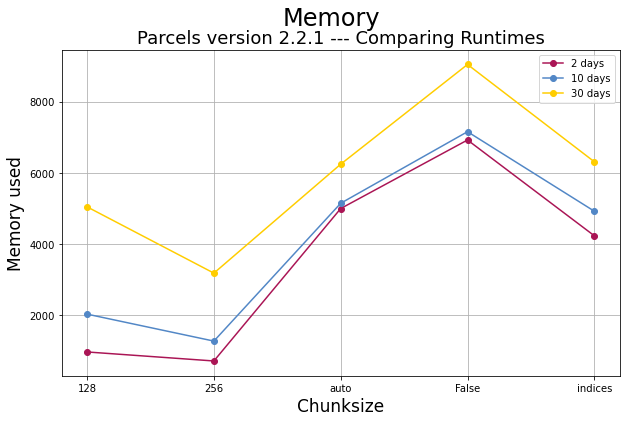

In [13]:
v=1
fig= plt.figure(figsize = (10,6))
ax = plt.axes()

fig.suptitle('Memory',fontsize=24)
ax.set_title(f'Parcels version {p_versions[v]} --- Comparing Runtimes', fontsize=18)

for i, rt in enumerate(runtime):
    ax.plot(mem[v,i].reshape(len(chunksizes),len(n_particles)), marker='o',c=runtime_cmap(i), label=f'{rt.days} days')
ax.grid()

ax.set_xticks(np.arange(0,len(chunksizes)))
ax.set_xticklabels(chunksizes)
ax.set_xlabel('Chunksize', fontsize=17)
ax.set_ylabel('Memory used', fontsize= 17)
ax.legend()